# Imports

In [1]:
import pandas as pd
from pathlib import Path
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

import os, math

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans, KernelKMeans, silhouette_score
from sklearn.cluster import KMeans

# Loading Data

In [2]:
with open("options.txt", 'r') as f:
    options = f.readlines()
    options = {option.split("=")[0]: option.split("=")[1].strip() for option in options}
print(options)

{'hanoi_scenario_dir': 'C:\\Users\\mjnst\\Desktop\\Thesis\\Hanoi_CMH\\Scenario-1', 'RUG_dir': 'C:\\Users\\mjnst\\Desktop\\Thesis\\RUG_data_5years', 'RUG_raw_csv': 'C:\\Users\\mjnst\\Desktop\\Thesis\\rug_csv.csv', 'RUG_timeseries': 'C:\\Users\\mjnst\\Desktop\\Thesis\\rug_timeseries.pkl', 'RUG_obfuscated': 'C:\\Users\\mjnst\\Desktop\\Thesis\\obfuscated_data.pkl'}


In [3]:
RUG = pd.read_pickle(options['RUG_obfuscated'])

# Preparing and Transforming Data

In [31]:
RUG.interpolate(method='linear', inplace=True, limit=20)

In [5]:
def create_groups(data):
    data_copy = data.copy()
    groups = data_copy.groupby(pd.Grouper(freq='D'))

    # get the calender date of the groups
    days = list(groups.first().index.strftime('%Y:%m:%d'))

    gro = [groups.get_group(x).reset_index(drop=True) for x in groups.groups]

    temp = pd.concat(gro, axis=1, keys=days)

    temp.index = pd.date_range("00:00", "23:59", freq="1min").strftime('%H:%M')

    # drop all columns of temp dataframe which contain nan values
    temp.dropna(axis=1, how='any', inplace=True)

    return temp[::10]

In [6]:
def scale_data(data):
    data_copy = data.copy()
    train_percentage = 0.8
    train_size = int(len(data_copy.columns) * train_percentage)

    train = data_copy.iloc[:, :train_size]
    test = data_copy.iloc[:, train_size:]

    scaler = MinMaxScaler(feature_range=(0, 1))

    scaled_list_train = [train[col] for col in train]
    scaled_list_train = scaler.fit_transform(scaled_list_train)
    
    scaled_list_test = [test[col] for col in test]
    scaled_list_test = scaler.transform(scaled_list_test)

    return scaled_list_train, scaled_list_test

In [26]:
def create_pca(data):

    data_copy = data.copy()
    # sns.set()
    
    # Reduce from 4 to 3 features with PCA
    # pca = PCA(n_components=cluster_count)
    pca = PCA(n_components=0.85, svd_solver='full')
    
    # Fit and transform data
    pca_features = pca.fit_transform(data_copy)
    

    # print('Shape before PCA: ', data_copy.shape)
    # print('Shape after PCA: ', pca_features.shape)

    # pca_df = pd.DataFrame(
    #     data=pca_features)

    # Bar plot of explained_variance
    # plt.bar(
    #     range(1,len(pca.explained_variance_)+1),
    #     pca.explained_variance_
    #     )
    
    
    # plt.xlabel('PCA Feature')
    # plt.ylabel('Explained variance')
    # plt.title('Feature Explained Variance')
    # plt.show()

    return pca_features

In [29]:
def kmeans_sillouette(data):
    data_copy = data.copy()
    wcss = []
    silhouette_scores = []
    for i in range(1,10):
        print(i)
        kmeans_pca = TimeSeriesKMeans(n_clusters=i, metric="dtw", n_jobs=-1).fit(data_copy)
        wcss.append(kmeans_pca.inertia_)
        try:
            silhouette_scores.append(silhouette_score(data_copy, kmeans_pca.labels_, n_jobs=-1))
        except:
            silhouette_scores.append(0)
    return wcss, silhouette_scores

In [30]:
def plot_scores(column, wcss, silhouette_scores):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(range(1,10), wcss, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.title(f'{column} K-means clustering')
    plt.subplot(1,2,2)
    plt.plot(range(1,10), silhouette_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette score')
    plt.title(f'{column} K-means clustering')
    plt.show()

In [31]:
def elbow(column):
    grouped_data = create_groups(RUG[column])

    scaled_list_train, scaled_list_test = scale_data(grouped_data)

    pca_data = create_pca(scaled_list_train)

    wcss, silhouette_scores = kmeans_sillouette(pca_data)

    plot_scores(column, wcss, silhouette_scores)


In [32]:
elbow('Location 2 - consumption')

1
2
3
4
5


In [ ]:
for i in RUG.columns:
    print(i)
    elbow(i)

# Added K-means

Text(0.5, 0, 'Number of clusters')

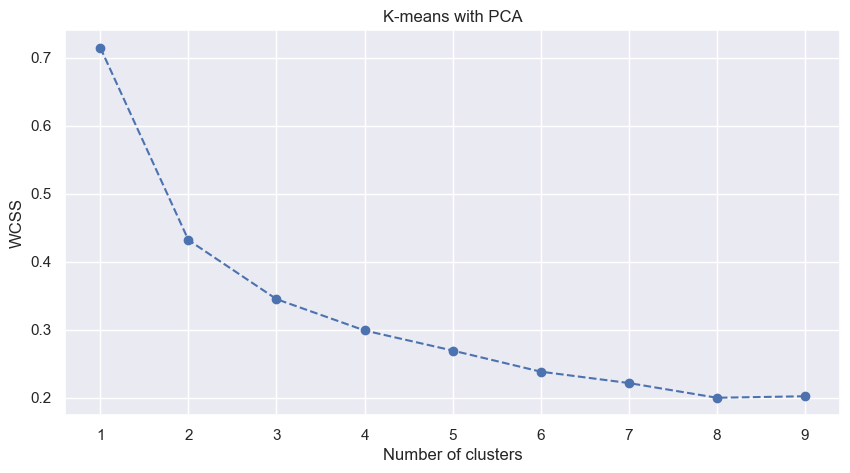

In [15]:
plt.figure(figsize=(10,5))
plt.plot(range(1,10), wcss, marker='o', linestyle='--')
plt.title('K-means with PCA')
plt.ylabel('WCSS')
plt.xlabel('Number of clusters')

ValueError: x and y must have same first dimension, but have shapes (9,) and (0,)

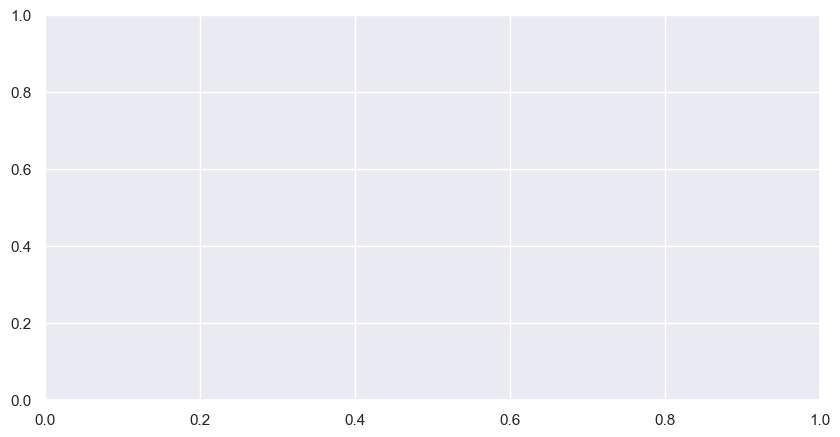

In [16]:
plt.figure(figsize=(10,5))
plt.plot(range(1,10), silhouette_scores, marker='o', linestyle='--')
plt.title('K-means with PCA')
plt.ylabel('Silhouette score')
plt.xlabel('Number of clusters')

from these graphs, we see that the elbow is at around 3, so we will use 3 clusters for the k-means algorithm.